## Create and test ion channel model

In [1]:
from experiments.ik1_markov import (goldoni_iv)

In [2]:
from ionchannelABC.experiment import setup

In [3]:
modelfile = 'models/ik1_markov.mmt'
#modelfile = 'models/Bondarenko2004_iK1.mmt'

In [4]:
observations, model, summary_statistics = setup(modelfile,
                                                goldoni_iv)

In [5]:
assert(len(observations)==len(summary_statistics(model({}))))

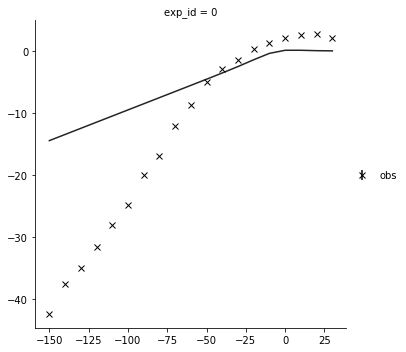

In [6]:
from ionchannelABC import plot_sim_results
g = plot_sim_results(modelfile, goldoni_iv)

## Set limits and generate uniform initial priors

In [7]:
from pyabc import Distribution, RV
limits = {'ik1.g_k1': (0., 1.),
          'log_ik1.p_1': (-7., 3.),
          'ik1.p_2': (1e-7, 0.4),
          'log_ik1.p_3': (-7., 3.),
          'ik1.p_4': (1e-7, 0.4)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [8]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl1_ik1.db"))

In [9]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [10]:
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 32 particles


In [11]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=2),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9999999999999998, '1': 0.9999999999999998, '2': 0.9999999999999998, '3': 0.9999999999999998, '4': 0.9999999999999998, '5': 0.9999999999999998, '6': 0.9999999999999998, '7': 0.9999999999999998, '8': 0.9999999999999998, '9': 0.9999999999999998, '10': 0.9999999999999998, '11': 0.9999999999999998, '12': 0.9999999999999998, '13': 0.9999999999999998, '14': 0.9999999999999998, '15': 0.9999999999999998, '16': 0.9999999999999998, '17': 0.9999999999999998, '18': 0.9999999999999998}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=20, quantile_multiplier=1


In [12]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [13]:
abc_id = abc.new(db_path, obs)

In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=200, min_acceptance_rate=0.005)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0


In [11]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc_continued = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(5000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=2),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9999999999999998, '1': 0.9999999999999998, '2': 0.9999999999999998, '3': 0.9999999999999998, '4': 0.9999999999999998, '5': 0.9999999999999998, '6': 0.9999999999999998, '7': 0.9999999999999998, '8': 0.9999999999999998, '9': 0.9999999999999998, '10': 0.9999999999999998, '11': 0.9999999999999998, '12': 0.9999999999999998, '13': 0.9999999999999998, '14': 0.9999999999999998, '15': 0.9999999999999998, '16': 0.9999999999999998, '17': 0.9999999999999998, '18': 0.9999999999999998, '19': 0.9999999999999998, '20': 0.9999999999999998, '21': 0.9999999999999998, '22': 0.9999999999999998, '23': 0.9999999999999998, '24': 0.9999999999999998, '25': 0.9999999999999998, '26': 0.9999999999999998, '27': 0.9999999999999998, '28': 0.9999999999999998, '29': 0.9999999999999998, '30': 0.9999999999999998, '31': 0.9999999999999998, '32': 0.9999999999999998, '33': 0.9999999999999998, '34': 0.9999999999999998, '35': 0.9999999999999998, '36': 0.9999999999999998, '37': 0.99999999

In [12]:
abc_continued.load(db_path, 1)

1

In [ ]:
history = abc_continued.run(minimum_epsilon=0., max_nr_populations=200, min_acceptance_rate=0.005)

INFO:Epsilon:initial epsilon is 0.14773941117236117
INFO:ABC:t:93 eps:0.14773941117236117
DEBUG:ABC:now submitting population 93


# Results analysis

In [4]:
from pyabc import History

In [5]:
db_path = 'sqlite:////storage/hhecm/cellrotor/chouston/abc-hl1-results/ik1/2/hl1_ik1.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2019-08-11 08:03:21.317493, end_time=2019-08-11 09:34:49.196253)>]

In [6]:
history.id = 1

In [7]:
df, w = history.get_distribution(m=0)

In [8]:
df.describe()

name,ik1.g_k1,ik1.p_2,ik1.p_4,log_ik1.p_1,log_ik1.p_3
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000
mean,6.127728e-02,0.022752,0.023154,-1.459766,-2.602970
std,7.822151e-11,0.012361,0.012361,2.403887,2.403887
min,6.127728e-02,0.000102,0.000010,-5.856121,-6.999325
25%,6.127728e-02,0.011594,0.012704,-3.520066,-4.663270
50%,6.127728e-02,0.022387,0.023520,-1.500421,-2.643625
75%,6.127728e-02,0.033202,0.034313,0.658346,-0.484857
max,6.127728e-02,0.045897,0.045805,2.994516,1.851312


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:158: RuntimeWarning: invalid value encountered in true_divide
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/pyt

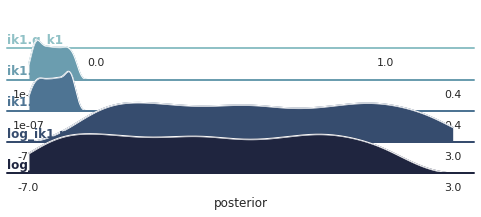

In [20]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

### Generating paper plots

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from ionchannelABC import plot_sim_results

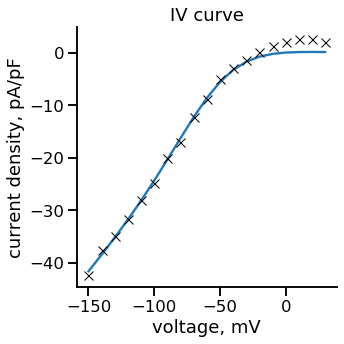

In [12]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile, goldoni_iv, df=df, w=w)

xlabels = ["voltage, mV"]
ylabels = ["current density, pA/pF"]
titles = ["IV curve"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
for ax, t in zip(g.axes.flatten(), titles):
    ax.set_title(t)
    
plt.tight_layout()

In [13]:
#g.savefig('/storage/hhecm/cellrotor/chouston/abc-hl1-results/ik1/calibrated.pdf')

In [10]:
from ionchannelABC import plot_experiment_traces

In [11]:
def split_iv(data):
    out = []
    for d in data.split_periodic(5100, adjust=True):
        out.append(d.trim(4950, 5100, adjust=True))
    return out

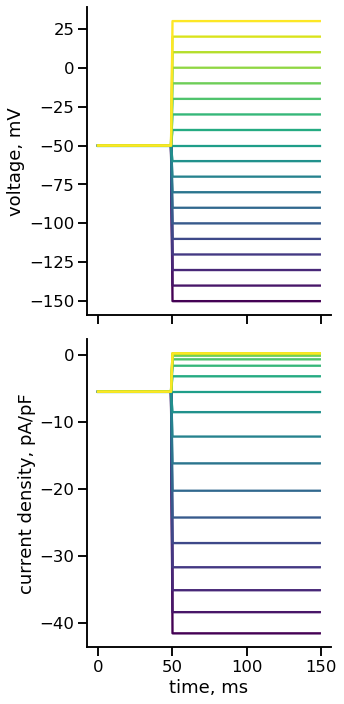

In [12]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_experiment_traces(modelfile, 'ik1.i_k1', [split_iv], goldoni_iv, 
                           df=df, w=w, log_interval=1, n_samples=100)

xl = "time, ms"
ylabels = ["voltage, mV", "current density, pA/pF"]
for ax in g.axes[1,:]:
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes, ylabels):
    ax[0].set_ylabel(yl)
for ax in g.axes.flatten():
    ax.set_title('')
    
plt.tight_layout()

In [13]:
#g.savefig('/storage/hhecm/cellrotor/chouston/abc-hl1-results/ik1/protocol.pdf')

In [26]:
def plot_sim_results_all(samples: pd.DataFrame):
    with sns.color_palette("gray"):
        grid = sns.relplot(x='x', y='y',
                           col='exp_id',
                           units='sample',
                           kind='line',
                           data=samples,
                           estimator=None, lw=0.5,
                           alpha=0.5,
                           #estimator=np.median,
                           facet_kws={'sharex': 'col',
                                      'sharey': 'col'})
    return grid

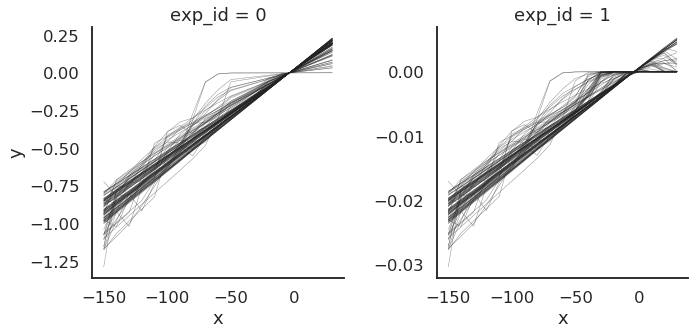

In [27]:
grid2 = plot_sim_results_all(samples)

In [33]:
#grid2.savefig('results/icat-generic/icat_sim_results_all.pdf')

In [35]:
import numpy as np

In [42]:
# Mean current density
print(np.mean(samples[samples.exp=='0'].groupby('sample').min()['y']))
# Std current density
print(np.std(samples[samples.exp=='0'].groupby('sample').min()['y']))

-0.9792263129382246
0.060452038127623814


In [43]:
import scipy.stats as st
peak_current = samples[samples['exp']=='0'].groupby('sample').min()['y'].tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))

In [44]:
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -0.9929750589235674
95% CI: (-1.0714884415582595, -0.8489199437971181)


In [45]:
# Voltage of peak current density
idxs = samples[samples.exp=='0'].groupby('sample').idxmin()['y']
print("mean: {}".format(np.mean(samples.iloc[idxs]['x'])))
print("STD: {}".format(np.std(samples.iloc[idxs]['x'])))

mean: -20.1
STD: 0.7


In [46]:
voltage_peak = samples.iloc[idxs]['x'].tolist()
rv = st.rv_discrete(values=(voltage_peak, [1/len(voltage_peak),]*len(voltage_peak)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -20.0
95% CI: (-20.0, -20.0)


In [48]:
# Half activation potential
# Fit of activation to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']=='1'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((Vhalf-V)/K))
    guess = (-30, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [49]:
print(np.mean(output))
print(np.std(output))

0   -33.399071
1     5.739255
dtype: float64
0    0.823473
1    0.366996
dtype: float64


In [50]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -33.407394098238164
95% CI: (-34.93130871417603, -31.973122716861205)


In [51]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.728938366573993
95% CI: (5.117385157850234, 6.485585591389819)


In [52]:
# Half activation potential
grouped = samples[samples['exp']=='2'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-100, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y,
                        bounds=([-100, 1], [0, 30]))
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [53]:
print(np.mean(output))
print(np.std(output))

0   -49.011222
1     4.399126
dtype: float64
0    0.613833
1    0.306758
dtype: float64


In [54]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -49.01404281457659
95% CI: (-50.06478757419054, -47.57952101705519)


In [55]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 4.420440009120772
95% CI: (3.7821747606540193, 4.959106709731536)


In [56]:
# Recovery time constant
grouped = samples[samples.exp=='3'].groupby('sample')
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 50)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]
output = grouped.apply(fit_single_exp)

In [57]:
print(np.mean(output))
print(np.std(output))

114.50830523453935
5.781251582667316


In [58]:
tau = output.tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 113.75533911706513
95% CI: (104.11137902797657, 125.98102619971708)
